## Executive Summary

Mutual funds remain the most popular investment tools of Canadian investors despite the growth of passive index funds which simply mirror the returns of the market as a whole. This report aims to determine if mutual funds are a good investment by comparing the returns of US and Canadian Equity mutual funds to the market returns. Using python and the yahoo finance API the returns of all large Canadian based mutual funds were examined. It was found that a passive strategy of investing in the market **would beat 68%** of Canadian equity mutual funds and a whopping **89%** of Canadian based US equity mutual funds. Considering many failed mutual funds change their names or are dropped, and that chances are if you beat the market this decade you may not the next, the market indexes are an even better investment than shown by this study.

## Introduction

Most Canadians investors are still invested in Mutual Funds despite a surge in the popularity of Exchange Traded Funds (ETFs). However many investment advisors consider mutual funds to be a bad investment due to certain factors such as the high expense ratios charged by many funds, hidden front-end and back-end load charges, the lack of control over investment decisions, and capital gains taxes being forced upon the fund holder.

Warren Buffet, arguably the best investor of all time, famously said "A low-cost index fund is the most sensible equity investment for the great majority of investors". The purpose of this report is to determine if that statement is true by comparing the performance of mutual funds to the market index.

## Methods

In order to compare mutual fund performance to the overall market we will do the following:

1. Use python jupyter notebooks and the relevant data science libraries to analyze the relevant data.
2. Download the symbol and name of every large Canadian and US Equity Mutual Fund.
3. Use the yahoo finance API to bring in the adjusted close price of the stock from January 2010 and from today.
5. Calculate the return of these funds and compare them to the returns of the TSX and S&P 500 which will represent the market in general.


### Load the Relevant Libraries

In [378]:
# Import libraries
from pandas_datareader import data as wb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
%matplotlib inline
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

### Sourcing the Data

We will use the yahoo mutual fund stock screener to find all Canadian mutual funds. The yahoo finance website has a fairly complete list of all mutual funds. We will use the yahoo mutual fund screener to select all mutual funds from Canada with over $1 billion in assets.

In [231]:
# Load the list of mutual funds
dfMutualFund = pd.read_csv("data/AllMutualFunds.csv")

We have 2197 Canadian mutual funds. Let's look at the first 5 rows:

In [232]:
dfMutualFund.head(5)

,Symbol,Name,Start,End
0,0P00007049.TO,GWL Real Estate (GWLRA) DSC,205.972000,363.507996
1,0P0000705I.TO,RBC Premium Money Market Fund A,9.707913,10.000000
2,0P00007060.TO,RBC Canadian Money Market Fund A,9.752143,10.000000
3,0P00007062.TO,RBC Balanced Fund A,10.539207,15.302900
4,0P00007067.TO,RBC Select Conservative Portfolio A,17.017159,23.600401


### Clean the Data

There are several things we have to do to make the data usable:

1. Remove index funds and bond funds - we are only interested in comparing actively managed mutual funds to the market.
2. Add columns for Start Price and End Price.
3. Remove any duplicates and check for null values.

In [233]:
# Drop null values
dfMutualFund.dropna(inplace=True)

In [234]:
# Remove index funds as these simply mirror the market
index_funds = [x for x in dfMutualFund['Name'] if 'Index' in x]
# Remove bond funds as we are interested in only equity funds
bond_funds = [x for x in dfMutualFund['Name'] if 'Bond' in x]
# Remove European funds 
eu_funds = [x for x in dfMutualFund['Name'] if 'European' in x]
# This deletes all records where the name is included in the index, bond or eu fund lists.
dfMutualFund = dfMutualFund[~dfMutualFund['Name'].isin(index_funds)]
dfMutualFund = dfMutualFund[~dfMutualFund['Name'].isin(bond_funds)]
dfMutualFund = dfMutualFund[~dfMutualFund['Name'].isin(eu_funds)]

In [235]:
# Let's also remove Real Estate Funds
dfMutualFund = dfMutualFund[~dfMutualFund['Name'].str.contains("Real Estate")] 

In [236]:
# Check how many funds remain
dfMutualFund.shape

(1918, 4)

Let's add columns for Start and End price.

In [54]:
# Let us add columsn for the start price and end price
dfMutualFund['Start'] = 0

In [55]:
dfMutualFund['End'] = 0

Let's add a row for the S&P/TSX Composite index. It's ticker is ^GSPTSE. We will also add a row for the S&P 500. It's ticker is ^GSPC.

In [59]:
# Add row for TSX to datarame
dfMutualFund = dfMutualFund.append({'Symbol' : '^GSPTSE' , 'Name' : 'S&P/TSX Composite index',
                             'Start': 0, 'End': 0} , ignore_index=True)

In [107]:
dfMutualFund = dfMutualFund.append({'Symbol' : '^GSPC' , 'Name' : 'American S&P 500',
                             'Start': 1132.989990, 'End': 3573.389893} , ignore_index=True)

### API: Adjusted Close Price

Now we can use Yahoo's API to update the start date and end date (today) adjusted close of the stock price for each ticker in our dataframe. The data will include the earliest recorded price in 2010 through to the most recent price, which would be today if the market is open. 

By slicing the data we can update the dataframe with only get the earliest and most recent price.

In [163]:
%%script false --no-raise-error
# Cdn tickers
cdn_tickers = CdnMutual['Symbol']
# List to hold start stock value and end stock value
startEndList = []

# We loop through each symbol and find it's start and end value 
# then we update the CdnMutual dataframe with these values
for t in cdn_tickers:
    try:
        startEndList = [wb.DataReader(t, data_source='yahoo', start='2010-1-1')['Adj Close'][0],
                        wb.DataReader(t, data_source='yahoo', start='2010-1-1')['Adj Close'][-1]]
        CdnMutual.loc[CdnMutual['Symbol'] == t, ['Start','End']] = startEndList
        print(t)
    except:
        print('Symbol not found')

We now have the adjusted close for the first trading day of the year and the most recent day for all our mutual funds.

In [340]:
dfMutualFund.head(5)

,Symbol,Name,Start,End
1,0P0000705I.TO,RBC Premium Money Market Fund A,9.707913,10.000000
2,0P00007060.TO,RBC Canadian Money Market Fund A,9.752143,10.000000
3,0P00007062.TO,RBC Balanced Fund A,10.539207,15.302900
4,0P00007067.TO,RBC Select Conservative Portfolio A,17.017159,23.600401
5,0P00007069.TO,RBC Select Growth Portfolio A,19.531996,33.855701


### Separate US and Canadian Funds

Our file contains data from all Canadian Equity based mutual funds. Some of these are U.S. Equity funds. These we need to compare to the S&P 500 so we will separate our dataframe into two dataframes, one for Canadian Equity, and the other for U.S. Equity.

In [165]:
# Split the Mutual Fund dataframe into two dataframes

In [240]:
CdnMutual = dfMutualFund[~((dfMutualFund['Name'].str.contains("U.S.")) | 
            (dfMutualFund['Name'].str.contains("American")))]

In [241]:
UsaMutual = dfMutualFund[((dfMutualFund['Name'].str.contains("U.S.")) | 
            (dfMutualFund['Name'].str.contains("American")))] 

## Results

Let's add a column in the dataframe for simple return and one for how much $100,000 invested 10 years ago would be worth now. 

The direct method to calculate the return or the holding period return over a single period of any length of time is:

${\displaystyle R={\frac {V_{f}-V_{i}}{V_{i}}}}$

where

$V_{f} = final\  adjusted\ close\  value$<br>
$V_{i} = initial\  adjusted\   close\  value$



In [242]:
# Calculate simple return for Canadian and US Mutual Funds
CdnMutual['Return'] = (CdnMutual['End'] - CdnMutual['Start']) / CdnMutual['Start'];

In [243]:
UsaMutual['Return'] = (UsaMutual['End'] - UsaMutual['Start']) / UsaMutual['Start'];

In [245]:
# Calculate what $100,000 invested 10 years ago is now
CdnMutual['WorthNow'] = 100_000 * (CdnMutual['Return'] + 1)

In [246]:
UsaMutual['WorthNow'] = 100_000 * (UsaMutual['Return'] + 1)

### Distributions of Returns

Let's examine how the returns are distributed. First the Canadian Funds. We have to exclude the row for the market.

In [280]:
CdnMutual.iloc[0:-1,:].describe()

,Start,End,Return,WorthNow
count,1755.000000,1755.000000,1755.000000,1755.000000
mean,11.934245,16.947203,0.409346,140934.616277
std,7.315737,13.484618,0.696012,69601.186041
min,2.377569,1.888500,-0.383730,61626.970551
25%,9.373582,10.820000,0.058980,105898.018710
50%,9.903299,13.125500,0.200682,120068.216878
75%,12.706271,18.398000,0.518147,151814.712405
max,207.317993,227.949005,8.495355,949535.543779


The median is $120,068. The minimum is $61,626 and the top mutual fund returned $949,535 on a $100,000 initial investment.

Then the US Funds.

In [283]:
UsaMutual.iloc[0:-1,:].describe()

,Start,End,Return,WorthNow
count,161.000000,161.000000,161.000000,161.000000
mean,11.322376,23.213231,1.132285,213228.505297
std,4.733921,16.006162,1.174743,117474.281666
min,2.059160,8.458100,-0.037666,96233.362118
25%,9.295448,15.023900,0.413438,141343.839539
50%,9.938763,17.278799,0.669985,166998.505772
75%,13.277391,26.990000,1.646810,264680.965663
max,32.354919,134.813995,6.248730,724873.023644


The median is $166,998. The minimum is $96,233 and the top mutual fund returned $724,873 on a $100,000 initial investment.

How does this compare to the market itself?

In [356]:
print(f"If you invested $100,000 in the TSX ten years ago it would be worth \
{'${:,.0f}'.format(CdnMutual.loc[CdnMutual['Symbol'] == '^GSPTSE', 'WorthNow'].values[0])} today.")

print(f"If the same amount was invested in the S&P500 it would be worth \
{'${:,.0f}'.format(UsaMutual.loc[UsaMutual['Symbol'] == '^GSPC', 'WorthNow'].values[0])} today")

If you invested $100,000 in the TSX ten years ago it would be worth $140,929 today.
If the same amount was invested in the S&P500 it would be worth $315,395 today


It is clear chances are you would be worse off by investing in a mutual fund compared to the market itself and this is especially true with the US Market. 

The market returns for the TSX are more than $20,000 more than the median value of mutual fund returns and the returns for the S&P500 are higher than 75% of US mutual funds.

### How do the Markets Compare?

The following graphs show the distribution of returns for Canadian and US Mutual funds. 

**The red lines on the graphs** show the returns of the market as a whole. 

Both distributions are heavily skewed to the right, which means there are fewer funds that make more than the market.

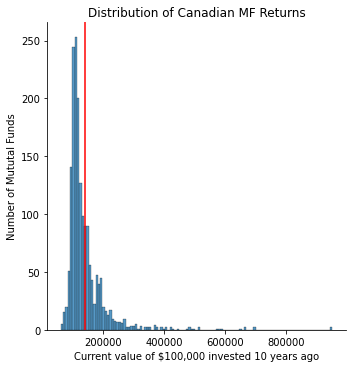

In [376]:
p1 = sns.displot(data=CdnMutual['WorthNow'], height=5);
plt.title("Distribution of Canadian MF Returns");
plt.xlabel("Current value of $100,000 invested 10 years ago");
plt.ylabel('Number of Mututal Funds')
plt.axvline(140_929, color='red'); # Plot a vertical line at corresponding x

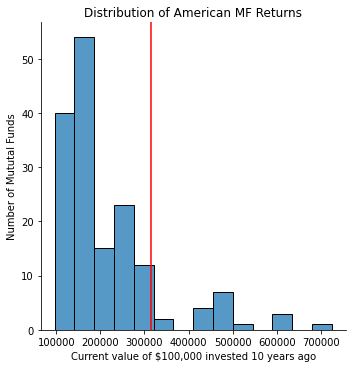

In [377]:
sns.displot(data=UsaMutual['WorthNow'], height=5);
plt.title("Distribution of American MF Returns");
plt.ylabel('Number of Mututal Funds')
plt.xlabel("Current value of $100,000 invested 10 years ago");
plt.axvline(315_395, color='red'); # Plot a vertical line at corresponding x

### Where does the Index Rank?

Let's use Python's stats function to calculate the percentile of the markets themselves. In other words this will tell us how the market itself ranks compared to the mutual funds. 

In [383]:
round(stats.percentileofscore(CdnMutual['WorthNow'], 140_929, kind='rank'),0)

68.0

In [384]:
round(stats.percentileofscore(UsaMutual['WorthNow'], 315_395, kind='rank'),0)

89.0

We can see that if someone simply invested in the market index of the TSX they would beat the returns of 68% of Canadian Equity mutual funds over the last 10 years. 

If they invested in the index of the S&P 500 they would beat the returns of 89% of all US Equity mutual funds. 

## Conclusions

A passive index fund of the TSX **beats 68%** of Canadian mutual funds that invest in the Canadian market. 
For Canadian Funds invested in US Equities the results are even more dramatic. A S&P Index Fund **beat 89%** of
Canadian based US Equity funds.

Losing Mutual funds are often pulled from the market. Also these results shown are over the last decade. If you do hold a mutual fund that beat the market in this time period, chances are it will not in the next decade. Therefore it's likely that mutual fund returns are even worse than this study showed. 

It seems that Warren Buffet was right when he said "A low-cost index fund is the most sensible equity investment for the great majority of investors". If you are invested in mutual funds you are often paying front and back end fees as well as high management expenses, odds are you would be much better off simply passively investing in the market.